In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense
import matplotlib.pyplot as plt

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/top-tech-companies-stock-price/List of SP 500 companies.csv
/kaggle/input/top-tech-companies-stock-price/Technology Sector List.csv
/kaggle/input/top-tech-companies-stock-price/Indices/IXIC.csv
/kaggle/input/top-tech-companies-stock-price/Indices/W5000.csv
/kaggle/input/top-tech-companies-stock-price/Indices/XLK.csv
/kaggle/input/top-tech-companies-stock-price/Indices/GSPC.csv
/kaggle/input/top-tech-companies-stock-price/Indices/DJI.csv
/kaggle/input/top-tech-companies-stock-price/Technology Companies/UBER.csv
/kaggle/input/top-tech-companies-stock-price/Technology Companies/TEL.csv
/kaggle/input/top-tech-companies-stock-price/Technology Companies/STM.csv
/kaggle/input/top-tech-companies-stock-price/Technology Companies/ANSS.csv
/kaggle/input/top-tech-companies-stock-price/Technology Companies/CRWD.csv
/kaggle/input/top-tech-companies-stock-price/Technology Companies/SAP.csv
/kaggle/input/top-tech-companies-stock-price/Technology Companies/MSFT.csv
/kaggle/input/top-tech-

# Stock Price Prediction Using GRU (Gated Recurrent Unit)

Stock price prediction is a challenging task due to the noisy and non-stationary nature of financial data. However, Recurrent Neural Networks (RNNs) have shown promise in capturing temporal dependencies in sequential data. In this notebook, we use a **Gated Recurrent Unit (GRU)**, a type of RNN, for predicting stock prices.

## What is GRU?

GRU is an advanced variant of RNN that helps overcome the **vanishing gradient problem** typically seen in vanilla RNNs. It introduces a gating mechanism to control the flow of information and decides what to keep and discard in the sequence, making it well-suited for time series data like stock prices. Unlike LSTM, which has separate forget and input gates, GRU combines these into a single **update gate**, making it computationally more efficient while retaining similar accuracy.

### GRU Mechanism:
GRU consists of two main gates:
1. **Update Gate**: Determines how much of the past information needs to be passed to the future.
2. **Reset Gate**: Controls how much of the previous state to forget.

These mechanisms allow GRUs to capture long-term dependencies in sequences, making them ideal for tasks where future values depend on previous values, such as stock price prediction.

## Why Use GRU for Stock Price Prediction?

1. **Handling Sequential Data**: Stock prices are inherently sequential. GRU models can effectively capture patterns over time and are able to make predictions based on historical data.
   
2. **Long-Term Dependencies**: Unlike traditional models, GRU can retain important information over long periods without vanishing gradients, making it capable of learning from long-term trends in the market.

3. **Efficiency**: GRUs have fewer parameters compared to LSTMs, making them faster to train while maintaining similar predictive power.

## Dataset

We use historical stock price data, including key features like:
- **Date**
- **Close** prices

The target variable is the **Close** price, which we aim to predict using the past sequence of prices.

## Approach

1. **Data Preprocessing**: We perform standard preprocessing steps like normalization and handling missing values to make the data suitable for the GRU model.
   
2. **Model Architecture**: We build a GRU-based model using `TensorFlow/Keras`. The architecture includes:
   - GRU layers for sequence learning
   - Dense layers for output prediction
   - Dropout layers to avoid overfitting

3. **Evaluation**: We use **KFold cross-validation** to evaluate the model's performance and avoid overfitting on a single train-test split.


### 1. **Mathematics of GRU**
For a given time step $t$, the GRU cell operates as follows:

#### a. **Update Gate** $z_t$
The update gate $z_t$ controls how much of the hidden state from the previous time step $h_{t-1}$ should be carried over to the current time step.

$$
z_t = \sigma(W_z \cdot [h_{t-1}, x_t] + b_z)
$$

- $\sigma$ is the sigmoid function.
- $W_z$ is the weight matrix for the update gate.
- $h_{t-1}$ is the previous hidden state.
- $x_t$ is the input at time $t$.
- $b_z$ is the bias term for the update gate.

The update gate $z_t$ takes values between 0 and 1, deciding how much of the past information should be retained.

#### b. **Reset Gate** $r_t$
The reset gate $r_t$ determines how much of the past hidden state should be ignored when calculating the new candidate hidden state $\tilde{h}_t$.

$$
r_t = \sigma(W_r \cdot [h_{t-1}, x_t] + b_r)
$$

- $W_r$ is the weight matrix for the reset gate.
- $b_r$ is the bias term for the reset gate.

#### c. **Candidate Hidden State** $\tilde{h}_t$
The candidate hidden state $\tilde{h}_t$ is computed based on the reset gate. If $r_t$ is close to 0, the previous hidden state is ignored. If $r_t$ is close to 1, more of the previous hidden state is considered.

$$
\tilde{h}_t = \tanh(W_h \cdot [r_t \odot h_{t-1}, x_t] + b_h)
$$

- $\odot$ represents the element-wise multiplication (Hadamard product).
- $\tanh$ is the hyperbolic tangent activation function.
- $W_h$ is the weight matrix for generating the candidate hidden state.
- $b_h$ is the bias term for the candidate hidden state.

#### d. **Final Hidden State** $h_t$
The final hidden state $h_t$ is a combination of the old hidden state $h_{t-1}$ and the candidate hidden state $\tilde{h}_t$, controlled by the update gate $z_t$.

$$
h_t = (1 - z_t) \odot h_{t-1} + z_t \odot \tilde{h}_t
$$

This means:
- If $z_t$ is close to 1, the new candidate hidden state $\tilde{h}_t$ is used.
- If $z_t$ is close to 0, the previous hidden state $h_{t-1}$ is retained.

### 2. **Sigmoid and Tanh Functions**
- **Sigmoid function**: $\sigma(x) = \frac{1}{1 + e^{-x}}$. The sigmoid function squashes values between 0 and 1, which is why it’s used for the gates. It ensures that the update and reset gates are a proportion (between 0 and 1) of the previous and candidate hidden states.
  
- **Tanh function**: $\tanh(x) = \frac{e^x - e^{-x}}{e^x + e^{-x}}$. The tanh function squashes values between -1 and 1, which is why it’s used for the candidate hidden state. It allows both positive and negative contributions to the hidden state.

### 3. **How GRU Handles Long-Term Dependencies**
The update gate $z_t$ helps GRU manage long-term dependencies by allowing the network to pass the hidden state across many time steps with minimal updates when needed. This means:
- If the update gate is close to 1, it allows the network to retain memory over a long period.
- If the update gate is close to 0, it forces the network to forget the past and focus more on the new information.

### 4. **Advantages of GRU Over Vanilla RNN**
- **Gating Mechanism**: GRU uses gates to control the flow of information, which helps in learning long-term dependencies better than simple RNNs, which suffer from vanishing gradient problems.
- **Fewer Parameters than LSTM**: GRU has a simpler structure than LSTM (Long Short-Term Memory), which makes it faster to train, especially on smaller datasets, while still capturing dependencies effectively.

### 5. **GRU for Stock Price Prediction**
For stock price prediction, GRU can effectively model both short-term fluctuations and long-term trends by using its gating mechanism to remember or forget past prices. The GRU’s hidden state captures dependencies over time, which is important for forecasting.

- The **input** $x_t$ can be features like the previous day’s closing price, volume, and other stock-related metrics.
- The **output** at each time step could be the predicted closing price for the next day or a specific future horizon.

### Summary of GRU Workflow
1. **Input** the current time step data $x_t$ and the previous hidden state $h_{t-1}$.
2. Compute the **update gate** $z_t$ and **reset gate** $r_t$.
3. Use the reset gate to decide how much of the previous hidden state $h_{t-1}$ to forget.
4. Compute the **candidate hidden state** $\tilde{h}_t$ using the current input and the modified previous hidden state.
5. Use the update gate to compute the **final hidden state** $h_t$ as a combination of the previous hidden state and the candidate hidden state.
6. Pass $h_t$ to the next time step and repeat.

By the end of the sequence, GRU should have learned useful patterns to predict the next time step (e.g., stock price).

---


# GRU implemention on all 5 indices:
1. IXIC
2. W5000
3. XLK
4. GSPC
5. DJI

In [3]:
p1="/kaggle/input/top-tech-companies-stock-price/Indices/IXIC.csv"
p2="/kaggle/input/top-tech-companies-stock-price/Indices/W5000.csv"
p3="/kaggle/input/top-tech-companies-stock-price/Indices/XLK.csv"
p4="/kaggle/input/top-tech-companies-stock-price/Indices/GSPC.csv"
p5="/kaggle/input/top-tech-companies-stock-price/Indices/DJI.csv"
stock_index={}
stock_index[0] = "IXIC"
stock_index[1] = "W5000"
stock_index[2] = "XLK"
stock_index[3] = "GSPC"
stock_index[4] = "DJI"

paths = [p1,p2,p3,p4,p5]
df = ["dummy"]*5
time_series = []
for i in range(len(paths)):
    df[i] = pd.read_csv(paths[i])
    time_series.append(df[i]['Close'])
# time_series is a list of all 5 index as its element 

In [4]:
def build_gru_model(input_shape,num_neurons):
    model = Sequential()
    model.add(GRU(num_neurons, return_sequences=False, input_shape=input_shape))
    model.add(Dense(1))  # Output layer
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

In [5]:
def create_sequences(data, sequence_length):
    X, y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data[i:i + sequence_length, 0])
        y.append(data[i + sequence_length, 0])
    return np.array(X), np.array(y)

In [6]:
def fit_gru(hyperparameter_k,hyperparameter_neurons, df, df_ind):
    print(f"Dataframe {stock_index[df_ind]} is being loaded ....")
    print(f"Training for sequence length: {hyperparameter_k}")
    print(f"Training on num neurons: {hyperparameter_neurons}")

    close_prices = df.values.reshape(-1, 1)

    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_close = scaler.fit_transform(close_prices)

    sequence_length = hyperparameter_k  
    X, y = create_sequences(scaled_close, sequence_length)

    # Reshape X for GRU input
    X = X.reshape((X.shape[0], X.shape[1], 1))

    # Train-test split (80% train, 20% test)
    train_size = int(len(X) * 0.8)
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]

    # Cross-validation using KFold
    kf = KFold(n_splits=5, shuffle=False)

    val_losses = []
    best_val_loss = float('inf')
    best_model = None

    for fold, (train_index, val_index) in enumerate(kf.split(X_train)):
        print(f"\nFold {fold + 1} training...")
        X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
        y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

        # Build and train the model
        model = build_gru_model((X_train_fold.shape[1], 1),hyperparameter_neurons)
        history = model.fit(X_train_fold, y_train_fold, epochs=10, batch_size=32, validation_data=(X_val_fold, y_val_fold))

        # Record the validation loss for this fold
        val_loss = history.history['val_loss'][-1]
        val_losses.append(val_loss)

        # Check if this is the best model based on validation loss
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model = model  # Save the model with the best validation loss

    # Print all validation losses
    print("\nValidation losses for each fold:")
    for fold, loss in enumerate(val_losses):
        print(f"Fold {fold + 1}: Validation Loss = {loss}")

    print(f"\nBest validation loss: {best_val_loss}")

    # Evaluate on test set using the best model
    predicted_test = best_model.predict(X_test)

    # Inverse scaling to compare with original prices
    predicted_test = scaler.inverse_transform(predicted_test)
    y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))
    mae = mean_absolute_error(predicted_test, y_test_actual)
    print(f"Mean Absolute Error is {mae}")

    # Plot the original vs predicted time series
    plt.figure(figsize=(10,6))
    plt.plot(y_test_actual, label="Actual Close Prices", color='blue')
    plt.plot(predicted_test, label="Predicted Close Prices", color='red')
    plt.title("Actual vs Predicted Close Prices")
    plt.xlabel("Time")
    plt.ylabel("Close Price")
    plt.legend()
    plt.show()
    
    return (hyperparameter_k, hyperparameter_neurons,best_model,mae)


Dataframe IXIC is being loaded ....
Training for sequence length: 30
Training on num neurons: 32

Fold 1 training...
Epoch 1/10


/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 0.0280 - val_loss: 4.0953e-04
Epoch 2/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 1.6004e-04 - val_loss: 1.6223e-05
Epoch 3/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 3.5625e-05 - val_loss: 1.2800e-05
Epoch 4/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 3.6182e-05 - val_loss: 1.2402e-05
Epoch 5/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 2.8291e-05 - val_loss: 1.2176e-05
Epoch 6/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 2.9220e-05 - val_loss: 1.2439e-05
Epoch 7/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 2.8035e-05 - val_loss: 1.1418e-05
Epoch 8/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 2.5685e-05 - val_loss: 1.1148e-05
Epoch 9/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 2.3945e-05 - val_loss: 1.0856e-05
Epoch 10/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 2.3269e-05 - val_loss: 1.0767e-05

Fold 2 training...
Epoch 1/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - loss: 0.007

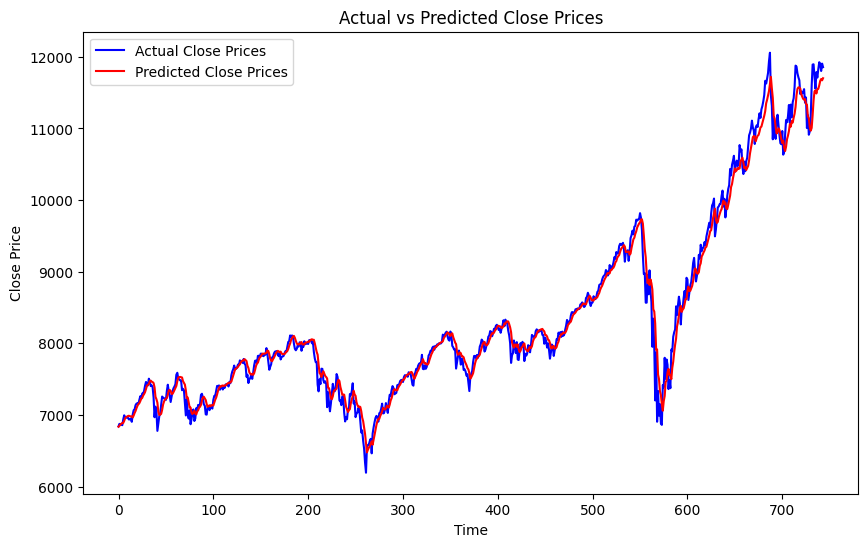

Dataframe IXIC is being loaded ....
Training for sequence length: 30
Training on num neurons: 50

Fold 1 training...
Epoch 1/10


/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 0.0149 - val_loss: 1.3822e-05
Epoch 2/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 4.7307e-05 - val_loss: 1.4718e-05
Epoch 3/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 3.2337e-05 - val_loss: 1.2706e-05
Epoch 4/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 3.0152e-05 - val_loss: 1.2483e-05
Epoch 5/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 2.9342e-05 - val_loss: 1.2022e-05
Epoch 6/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 2.6736e-05 - val_loss: 1.2555e-05
Epoch 7/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 2.5586e-05 - val_loss: 1.2841e-05
Epoch 8/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 2.5476e-05 - val_loss: 1.1302e-05
Epoch 9/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 2.4043e-05 - val_loss: 1.1836e-05
Epoch 10/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 2.4442e-05 - val_loss: 1.0921e-05

Fold 2 training...
Epoch 1/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - loss: 0.024

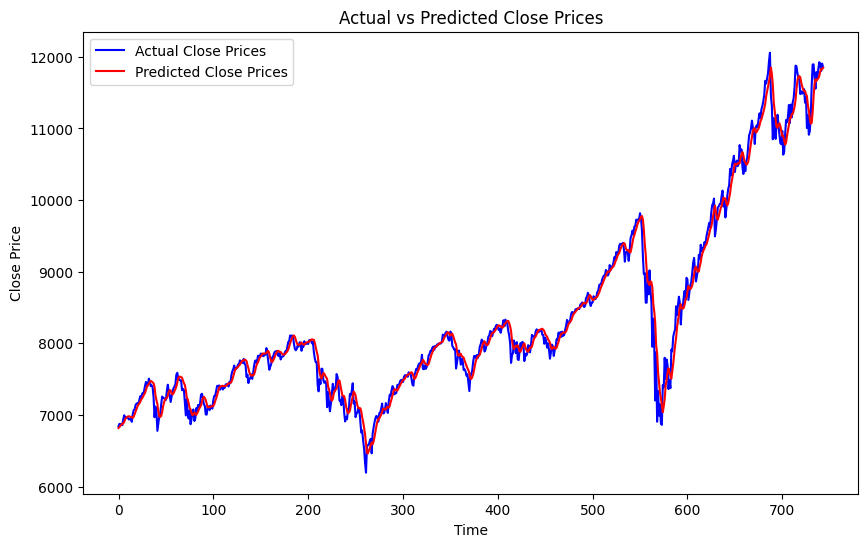

Dataframe IXIC is being loaded ....
Training for sequence length: 30
Training on num neurons: 70

Fold 1 training...
Epoch 1/10


/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


75/75 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - loss: 0.0220 - val_loss: 4.7297e-05
Epoch 2/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 5.2201e-05 - val_loss: 1.5214e-05
Epoch 3/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 3.1820e-05 - val_loss: 1.6065e-05
Epoch 4/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 3.3374e-05 - val_loss: 1.3310e-05
Epoch 5/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 3.0252e-05 - val_loss: 1.3084e-05
Epoch 6/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 2.9429e-05 - val_loss: 1.4795e-05
Epoch 7/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 3.1090e-05 - val_loss: 1.2505e-05
Epoch 8/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 3.0169e-05 - val_loss: 1.7479e-05
Epoch 9/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 2.7750e-05 - val_loss: 1.2043e-05
Epoch 10/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 2.6884e-05 - val_loss: 1.3055e-05

Fold 2 training...
Epoch 1/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 0.003

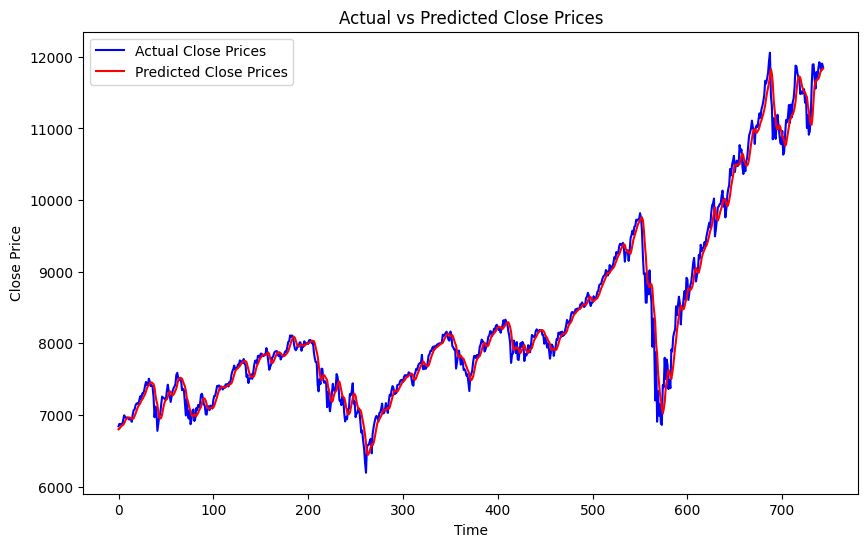

Dataframe IXIC is being loaded ....
Training for sequence length: 60
Training on num neurons: 32

Fold 1 training...
Epoch 1/10


/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


74/74 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - loss: 0.0087 - val_loss: 5.2573e-05
Epoch 2/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 3.0837e-05 - val_loss: 1.0869e-05
Epoch 3/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 2.3368e-05 - val_loss: 1.0757e-05
Epoch 4/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 2.3459e-05 - val_loss: 1.0388e-05
Epoch 5/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 2.1884e-05 - val_loss: 1.0280e-05
Epoch 6/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 2.2967e-05 - val_loss: 1.0333e-05
Epoch 7/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 2.1671e-05 - val_loss: 1.1737e-05
Epoch 8/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 2.2359e-05 - val_loss: 1.2192e-05
Epoch 9/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 1.9585e-05 - val_loss: 1.0262e-05
Epoch 10/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 2.0053e-05 - val_loss: 9.3743e-06

Fold 2 training...
Epoch 1/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - loss: 0.017

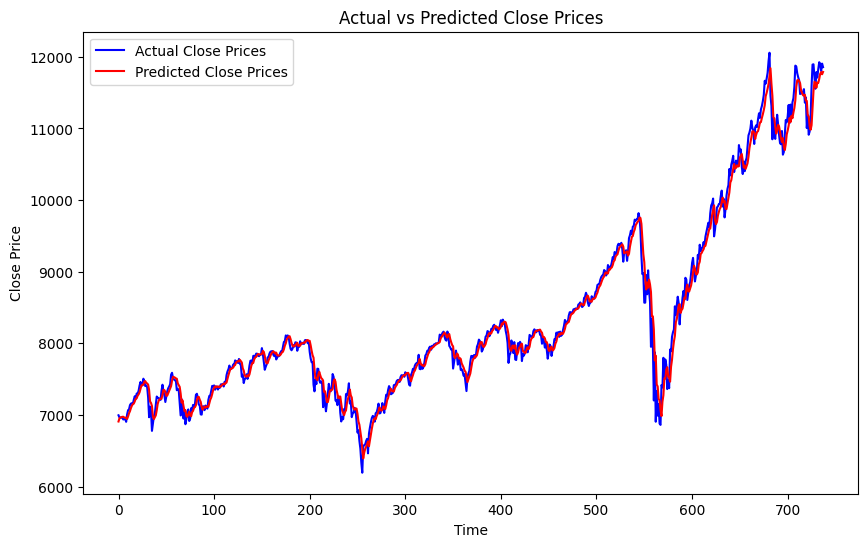

Dataframe IXIC is being loaded ....
Training for sequence length: 60
Training on num neurons: 50

Fold 1 training...
Epoch 1/10


/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


74/74 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step - loss: 0.0324 - val_loss: 1.9736e-04
Epoch 2/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 1.0707e-04 - val_loss: 1.7744e-05
Epoch 3/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 4.3110e-05 - val_loss: 2.0504e-05
Epoch 4/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 4.1605e-05 - val_loss: 1.7192e-05
Epoch 5/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 3.6844e-05 - val_loss: 1.5297e-05
Epoch 6/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 3.3363e-05 - val_loss: 1.4798e-05
Epoch 7/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 3.2590e-05 - val_loss: 1.4953e-05
Epoch 8/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 2.7393e-05 - val_loss: 1.4378e-05
Epoch 9/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 2.9659e-05 - val_loss: 1.3918e-05
Epoch 10/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 2.9225e-05 - val_loss: 1.4357e-05

Fold 2 training...
Epoch 1/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 5s 37ms/step - loss: 0.012

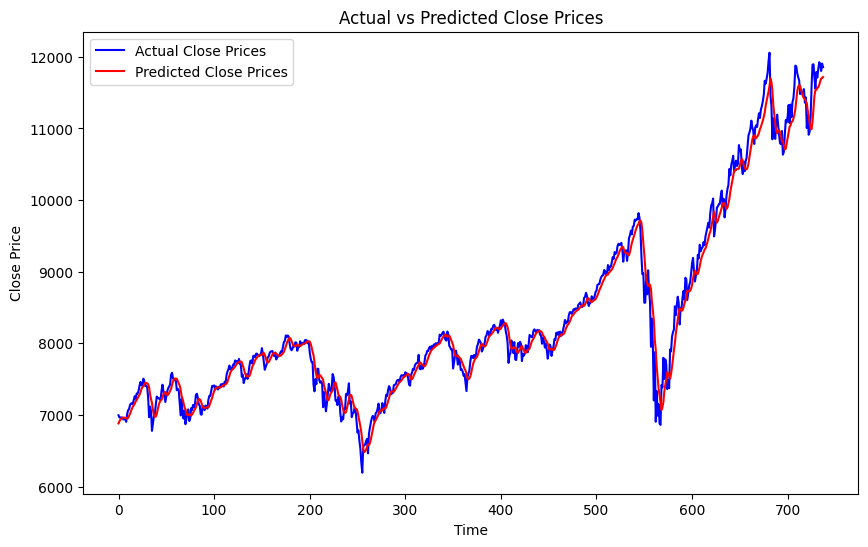

Dataframe IXIC is being loaded ....
Training for sequence length: 60
Training on num neurons: 70

Fold 1 training...
Epoch 1/10


/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


74/74 ━━━━━━━━━━━━━━━━━━━━ 5s 40ms/step - loss: 0.0221 - val_loss: 3.1286e-05
Epoch 2/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - loss: 4.9043e-05 - val_loss: 1.4844e-05
Epoch 3/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - loss: 3.3936e-05 - val_loss: 1.4525e-05
Epoch 4/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - loss: 3.4980e-05 - val_loss: 1.4642e-05
Epoch 5/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - loss: 2.9958e-05 - val_loss: 1.4790e-05
Epoch 6/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - loss: 2.9277e-05 - val_loss: 1.6386e-05
Epoch 7/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - loss: 2.8100e-05 - val_loss: 1.2832e-05
Epoch 8/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - loss: 2.7228e-05 - val_loss: 1.2525e-05
Epoch 9/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - loss: 2.6506e-05 - val_loss: 1.2428e-05
Epoch 10/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - loss: 2.4031e-05 - val_loss: 1.1976e-05

Fold 2 training...
Epoch 1/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 5s 41ms/step - loss: 0.012

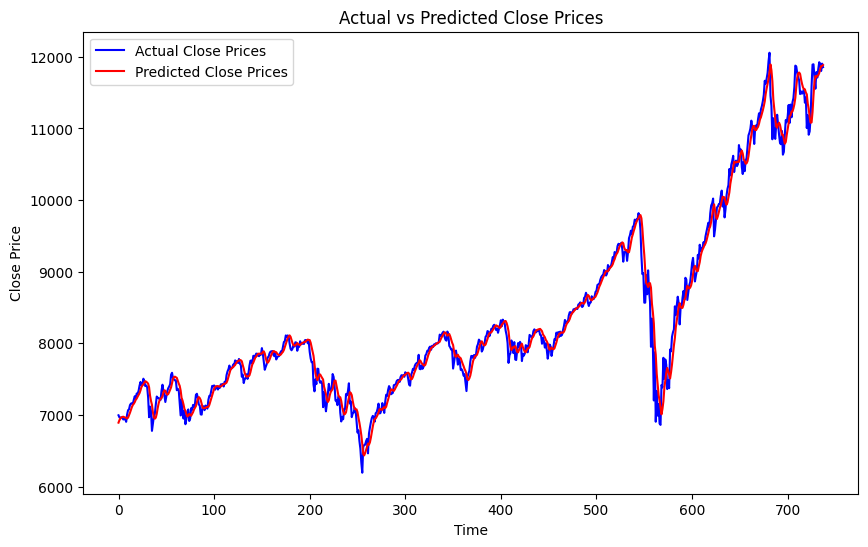

Dataframe IXIC is being loaded ....
Training for sequence length: 90
Training on num neurons: 32

Fold 1 training...
Epoch 1/10


/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


74/74 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step - loss: 0.0215 - val_loss: 0.0015
Epoch 2/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - loss: 5.1325e-04 - val_loss: 1.5923e-05
Epoch 3/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - loss: 3.1741e-05 - val_loss: 1.4119e-05
Epoch 4/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - loss: 2.9861e-05 - val_loss: 1.3932e-05
Epoch 5/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - loss: 2.8076e-05 - val_loss: 1.5573e-05
Epoch 6/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - loss: 2.8659e-05 - val_loss: 1.3115e-05
Epoch 7/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - loss: 2.6307e-05 - val_loss: 1.2684e-05
Epoch 8/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - loss: 2.5779e-05 - val_loss: 1.3333e-05
Epoch 9/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - loss: 2.4987e-05 - val_loss: 1.2235e-05
Epoch 10/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - loss: 2.3588e-05 - val_loss: 1.2251e-05

Fold 2 training...
Epoch 1/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 5s 47ms/step - loss: 0.0097 - 

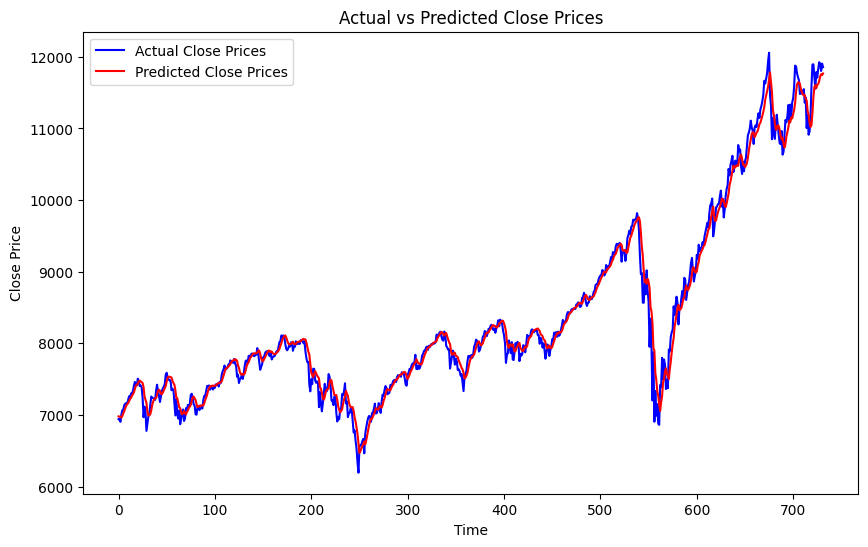

Dataframe IXIC is being loaded ....
Training for sequence length: 90
Training on num neurons: 50

Fold 1 training...
Epoch 1/10


/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


74/74 ━━━━━━━━━━━━━━━━━━━━ 6s 55ms/step - loss: 0.0156 - val_loss: 6.1350e-05
Epoch 2/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 4s 51ms/step - loss: 3.5811e-05 - val_loss: 1.5359e-05
Epoch 3/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 4s 52ms/step - loss: 3.0337e-05 - val_loss: 1.3709e-05
Epoch 4/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 4s 52ms/step - loss: 2.6996e-05 - val_loss: 1.4054e-05
Epoch 5/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 4s 50ms/step - loss: 2.9077e-05 - val_loss: 1.6360e-05
Epoch 6/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 4s 51ms/step - loss: 3.0017e-05 - val_loss: 1.3308e-05
Epoch 7/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 5s 51ms/step - loss: 2.8017e-05 - val_loss: 1.2856e-05
Epoch 8/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 4s 51ms/step - loss: 2.3638e-05 - val_loss: 1.3300e-05
Epoch 9/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 4s 50ms/step - loss: 2.5115e-05 - val_loss: 1.3684e-05
Epoch 10/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 4s 51ms/step - loss: 2.4640e-05 - val_loss: 1.1907e-05

Fold 2 training...
Epoch 1/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 6s 54ms/step - loss: 0.030

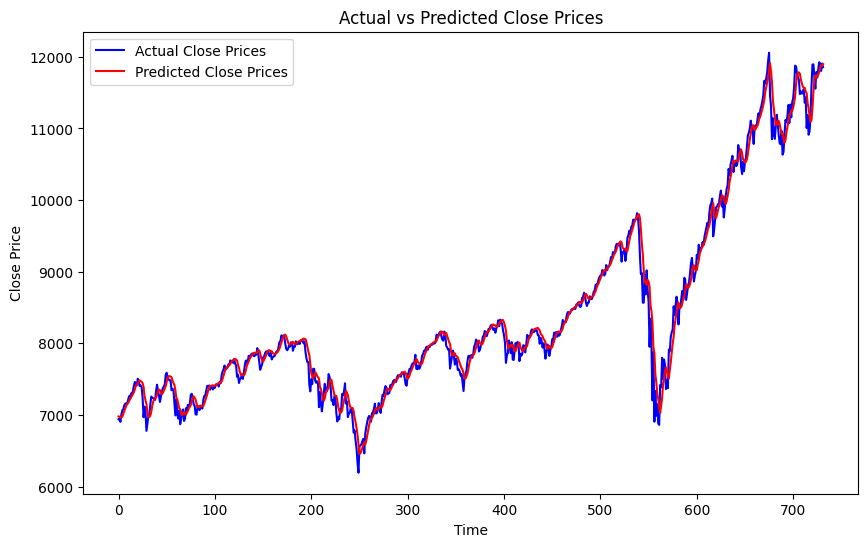

Dataframe IXIC is being loaded ....
Training for sequence length: 90
Training on num neurons: 70

Fold 1 training...
Epoch 1/10


/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


74/74 ━━━━━━━━━━━━━━━━━━━━ 6s 60ms/step - loss: 0.0266 - val_loss: 4.6308e-05
Epoch 2/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 4s 57ms/step - loss: 6.1677e-05 - val_loss: 1.6379e-05
Epoch 3/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 4s 55ms/step - loss: 3.3045e-05 - val_loss: 1.7081e-05
Epoch 4/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 4s 56ms/step - loss: 3.2892e-05 - val_loss: 1.5374e-05
Epoch 5/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 4s 57ms/step - loss: 3.0379e-05 - val_loss: 1.7764e-05
Epoch 6/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 4s 56ms/step - loss: 3.2129e-05 - val_loss: 1.5747e-05
Epoch 7/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 4s 56ms/step - loss: 3.0386e-05 - val_loss: 1.4343e-05
Epoch 8/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 4s 55ms/step - loss: 2.9205e-05 - val_loss: 1.4744e-05
Epoch 9/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 4s 56ms/step - loss: 2.8738e-05 - val_loss: 1.3715e-05
Epoch 10/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 4s 55ms/step - loss: 3.0230e-05 - val_loss: 1.7337e-05

Fold 2 training...
Epoch 1/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 6s 60ms/step - loss: 0.013

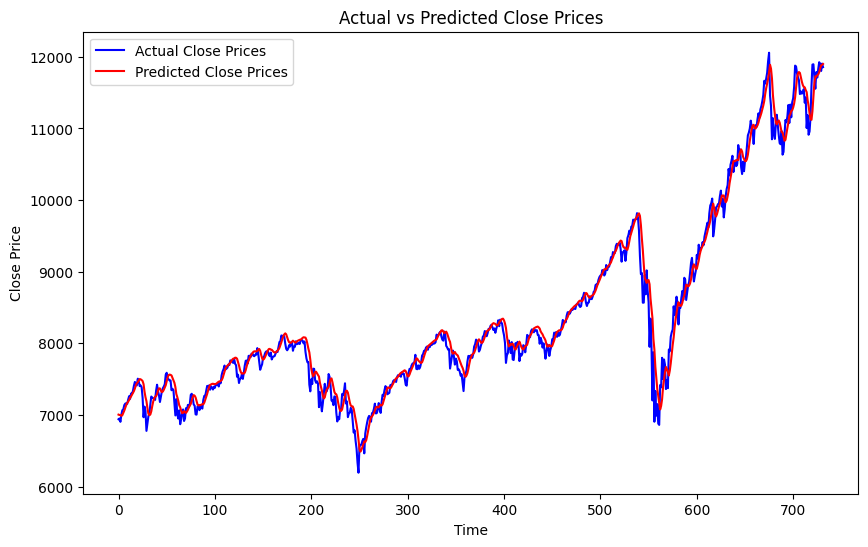

Dataframe IXIC is being loaded ....
Training for sequence length: 120
Training on num neurons: 32

Fold 1 training...
Epoch 1/10


/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


73/73 ━━━━━━━━━━━━━━━━━━━━ 7s 65ms/step - loss: 0.0455 - val_loss: 0.0036
Epoch 2/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 5s 63ms/step - loss: 0.0011 - val_loss: 3.8109e-05
Epoch 3/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 4s 61ms/step - loss: 4.7164e-05 - val_loss: 3.3697e-05
Epoch 4/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 5s 62ms/step - loss: 4.0985e-05 - val_loss: 2.8339e-05
Epoch 5/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 4s 60ms/step - loss: 4.2862e-05 - val_loss: 2.5483e-05
Epoch 6/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 4s 60ms/step - loss: 3.6654e-05 - val_loss: 2.5962e-05
Epoch 7/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 4s 60ms/step - loss: 3.9692e-05 - val_loss: 2.3567e-05
Epoch 8/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 4s 60ms/step - loss: 3.1201e-05 - val_loss: 2.3842e-05
Epoch 9/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 4s 60ms/step - loss: 3.7567e-05 - val_loss: 2.2214e-05
Epoch 10/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 4s 60ms/step - loss: 3.3510e-05 - val_loss: 2.1759e-05

Fold 2 training...
Epoch 1/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 6s 63ms/step - loss: 0.0515 - val_

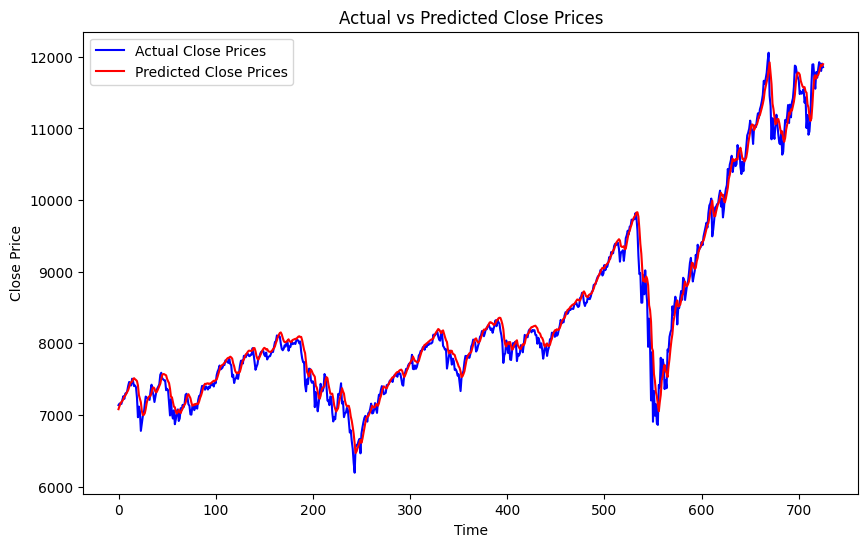

Dataframe IXIC is being loaded ....
Training for sequence length: 120
Training on num neurons: 50

Fold 1 training...
Epoch 1/10


/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


73/73 ━━━━━━━━━━━━━━━━━━━━ 7s 71ms/step - loss: 0.0146 - val_loss: 2.1056e-05
Epoch 2/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 5s 67ms/step - loss: 4.7792e-05 - val_loss: 2.2071e-05
Epoch 3/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 5s 67ms/step - loss: 3.4852e-05 - val_loss: 2.0144e-05
Epoch 4/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 5s 67ms/step - loss: 3.0968e-05 - val_loss: 1.9701e-05
Epoch 5/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 5s 68ms/step - loss: 2.7952e-05 - val_loss: 2.3262e-05
Epoch 6/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 5s 67ms/step - loss: 2.8894e-05 - val_loss: 2.1350e-05
Epoch 7/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 5s 67ms/step - loss: 2.9619e-05 - val_loss: 1.8786e-05
Epoch 8/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 5s 67ms/step - loss: 2.5781e-05 - val_loss: 1.7796e-05
Epoch 9/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 5s 67ms/step - loss: 2.5449e-05 - val_loss: 1.7021e-05
Epoch 10/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 6s 80ms/step - loss: 2.4058e-05 - val_loss: 1.8353e-05

Fold 2 training...
Epoch 1/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 7s 72ms/step - loss: 0.011

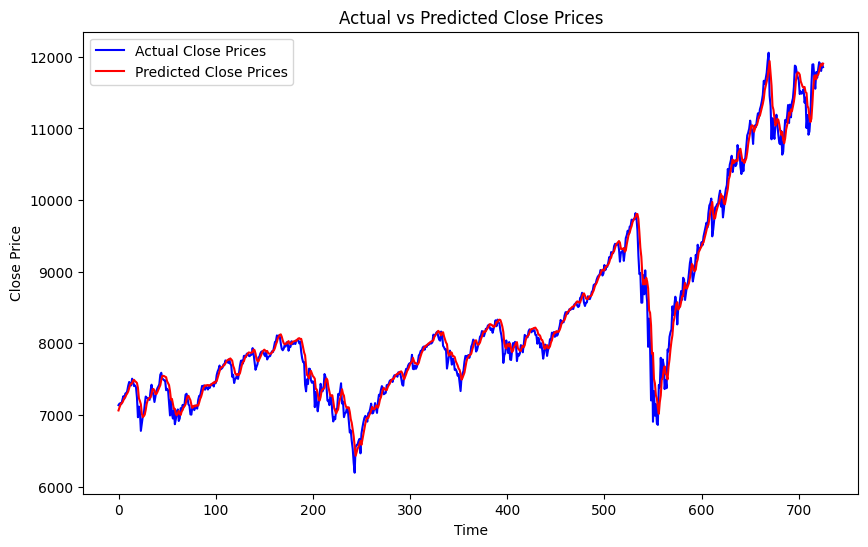

Dataframe IXIC is being loaded ....
Training for sequence length: 120
Training on num neurons: 70

Fold 1 training...
Epoch 1/10


/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


73/73 ━━━━━━━━━━━━━━━━━━━━ 8s 80ms/step - loss: 0.0145 - val_loss: 2.3915e-05
Epoch 2/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 5s 73ms/step - loss: 3.5516e-05 - val_loss: 1.8437e-05
Epoch 3/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 5s 75ms/step - loss: 2.7779e-05 - val_loss: 1.8941e-05
Epoch 4/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 5s 74ms/step - loss: 2.6993e-05 - val_loss: 1.7548e-05
Epoch 5/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 5s 75ms/step - loss: 2.6270e-05 - val_loss: 1.7060e-05
Epoch 6/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 5s 74ms/step - loss: 2.5525e-05 - val_loss: 1.6243e-05
Epoch 7/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 5s 74ms/step - loss: 2.4354e-05 - val_loss: 1.6709e-05
Epoch 8/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 5s 72ms/step - loss: 2.3724e-05 - val_loss: 1.5557e-05
Epoch 9/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 5s 71ms/step - loss: 2.3166e-05 - val_loss: 2.0019e-05
Epoch 10/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 5s 71ms/step - loss: 2.3700e-05 - val_loss: 1.4796e-05

Fold 2 training...
Epoch 1/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 7s 77ms/step - loss: 0.015

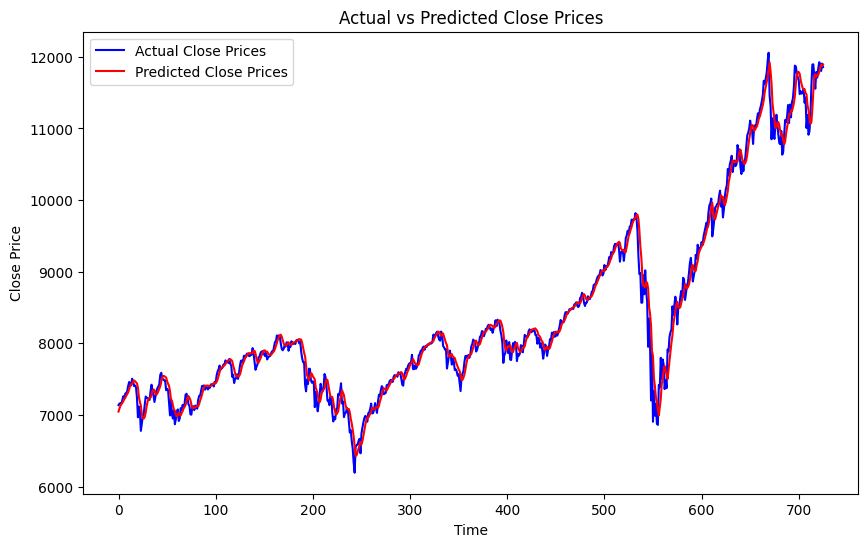

AttributeError: 'numpy.float64' object has no attribute 'save'

In [7]:
# This will run for about 20-25 mins
k = [30,60,90,120]
neurons = [32,50,70]
models={}
for i in range(len(time_series)):
    model_desc = []
    for hyperparameter_k in k:
        for hyperparameter_neurons in neurons:
            model_desc.append(fit_gru(hyperparameter_k,hyperparameter_neurons,time_series[i],i))
    best_tuned = (1,1,1,float('inf') ) # dummy init
    for model in model_desc:
        if (model[3]<best_tuned[3]):
            best_tuned = model
    models[stock_index[i]] = best_tuned
    best_tuned[3].save(f"gru_{stock_index[i]}_model.h5")
    print ("\n\n\n\n\n")
    
print (models)


# Results of Hyperparameter tuning of GRU implementation

In [ ]:
for stock, best_model in models.items():
    print(f"Stock: {stock}")
    print(f"  Hyperparameter k: {best_model[0]}")
    print(f"  Hyperparameter neurons: {best_model[1]}")
    print(f"  Model ID: {best_model[2]}")
    print(f"  Model Loss: {best_model[3]}")
    print("\n" + "-"*50 + "\n")  # Divider between models


# Stock Price Prediction Using Support Vector Regression (SVR)

Predicting stock prices is a complex problem due to market volatility, non-linear relationships, and the influence of numerous factors. One powerful approach for capturing non-linear patterns is **Support Vector Regression (SVR)**, which is an extension of the Support Vector Machine (SVM) technique for regression tasks.

## What is SVR?

**Support Vector Regression (SVR)** is a type of regression model based on the principles of **Support Vector Machines (SVM)**. SVR aims to find a function that approximates the relationship between input features and a continuous output (e.g., stock prices). Unlike linear regression, SVR can model **non-linear relationships** using different kernel functions.

### Key Concepts:
1. **Epsilon-insensitive loss**: SVR introduces a margin of tolerance (epsilon) within which errors are ignored, and the model does not penalize predictions. This creates a "tube" around the true data, allowing some flexibility.
   
2. **Support Vectors**: Only data points that fall outside this epsilon margin contribute to defining the model, making SVR less sensitive to outliers.

3. **Kernels**: SVR can use various kernel functions (e.g., **linear, polynomial, radial basis function (RBF)**) to map the data into higher-dimensional spaces, enabling it to capture complex, non-linear relationships in stock price movements.

## Why Use SVR for Stock Price Prediction?

1. **Handling Non-Linear Relationships**: Stock prices are influenced by multiple non-linear factors, and SVR, especially with non-linear kernels like **RBF**, can capture these complex patterns better than linear models.

2. **Robustness to Outliers**: SVR focuses on the most important data points (support vectors) and ignores insignificant data, making it robust to noisy stock data, where occasional large fluctuations can occur.

3. **Generalization**: SVR is known for its ability to generalize well, meaning it is less likely to overfit to training data, especially when tuned carefully with cross-validation.

## Dataset

We use historical stock price data that includes features like:
- **Date**
- **Close** prices


The goal is to predict the **Close** price of the stock using the past features and other relevant information.

## Approach

1. **Data Preprocessing**: We first normalize the features (stock prices, volume) to ensure the data is on a consistent scale for SVR.

2. **Modeling with SVR**: We implement an SVR model using **`scikit-learn`**. The model is configured with the following:
   - **Kernel**: We experiment with different kernels (e.g., RBF, linear) to capture both linear and non-linear relationships in the stock price data.
   - **Hyperparameter tuning**: Parameters like **C**, **epsilon**, and **gamma** are optimized using grid search or random search techniques to find the best model configuration.

3. **Evaluation**: We evaluate the SVR model using metrics such as **Mean Squared Error (MSE)** and **Mean Absolute Error (MAE)**, comparing its performance with other models like GRU.


# Support Vector Regression on all 5 indices

In [ ]:
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error

In [ ]:
def fit_svr(hyperparameter_k, hyperparameter_c, hyperparameter_gamma, df, df_ind):
#     print (f"Dataset {stock_index[df_ind]} is being loaded ... ")
#     print(f"Training for sequence length: {hyperparameter_k}, C: {hyperparameter_c}, Gamma: {hyperparameter_gamma}")
    close_prices = df.values.reshape(-1, 1)
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_close = scaler.fit_transform(close_prices)
    
    sequence_length = hyperparameter_k  
    X, y = create_sequences(scaled_close, sequence_length)

    # Train-test split (80% train, 20% test)
    train_size = int(len(X) * 0.8)
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]

    # Reshape X for SVR input (flatten the sequences)
    X_train_svr = X_train.reshape(X_train.shape[0], -1)
    X_test_svr = X_test.reshape(X_test.shape[0], -1)

    # Cross-validation using KFold
    kf = KFold(n_splits=5, shuffle=False)

    # To store validation losses and the best model
    best_val_loss = float('inf')
    best_model = None
    best_hyperparameters = None

    # Train SVR with KFold
    for fold, (train_index, val_index) in enumerate(kf.split(X_train_svr)):
        X_train_fold, X_val_fold = X_train_svr[train_index], X_train_svr[val_index]
        y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

        # Define the SVR model
        svr_model = SVR(kernel='rbf', C=hyperparameter_c, gamma=hyperparameter_gamma, epsilon=0.01)

        # Train the model
        svr_model.fit(X_train_fold, y_train_fold)

        # Validation predictions and loss
        y_val_pred = svr_model.predict(X_val_fold)
        val_loss = mean_squared_error(y_val_fold, y_val_pred)

        # Keep track of the best model
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model = svr_model
            best_hyperparameters = (hyperparameter_k, hyperparameter_c, hyperparameter_gamma)

    # Final evaluation on the test set with the best model
    y_test_pred = best_model.predict(X_test_svr)
    
    # Inverse scaling to compare with original prices
    y_test_pred_actual = scaler.inverse_transform(y_test_pred.reshape(-1, 1))
    y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))
    
    # Print test performance
    test_loss = mean_absolute_error(y_test_pred_actual, y_test_actual)
#     print(f"Best Model: k={best_hyperparameters[0]}, C={best_hyperparameters[1]}, Gamma={best_hyperparameters[2]}")
#     print(f"Validation Loss: {best_val_loss}, Test Loss: {test_loss}")

#     # Plot the actual vs predicted close prices
#     plt.figure(figsize=(10, 6))
#     plt.plot(y_test_actual, label="Actual Close Prices", color='blue')
#     plt.plot(y_test_pred_actual, label="Predicted Close Prices (SVR)", color='red')
#     plt.title(f"Actual vs Predicted Close Prices (SVR) - Best Model")
#     plt.xlabel("Time")
#     plt.ylabel("Close Price")
#     plt.legend()
#     plt.show()

    return best_model, best_hyperparameters, best_val_loss, test_loss, y_test_pred_actual , y_test_actual


In [ ]:
# Grid search setup
k_values = [30, 60, 90]
c_values = [0.1, 0.5, 1, 2, 4, 16, 32, 64, 128, 512, 1000, 2000]
gamma_values = np.arange(0.01, 0.1, 0.01).tolist()
# Perform the grid search for each time series
for i in range(len(time_series)):
    best_overall_model = None
    best_overall_hyperparameters = None
    best_overall_val_loss = float('inf')
    best_overall_test_loss = float('inf')
    best_yp = None
    best_ya = None
    for hyperparameter_k in k_values:
        for hyperparameter_c in c_values:
            for hyperparameter_gamma in gamma_values:
                model, hyperparameters, val_loss, test_loss,yp,ya = fit_svr(hyperparameter_k, hyperparameter_c, hyperparameter_gamma, time_series[i], i)
                
                # Track the overall best model across all searches
                if val_loss < best_overall_val_loss:
                    best_overall_val_loss = val_loss
                    best_overall_test_loss = test_loss
                    best_overall_model = model
                    best_overall_hyperparameters = hyperparameters
                    best_yp = yp
                    best_ya = ya
    print (f"Grid search completed Dataset {stock_index[i]}")
    # Save the entire model (architecture, weights, optimizer state, etc.)
    best_overall_model.save(f"svr_{stock_index[i]}_model.h5")

    # Print the best overall results
    print(f"Best Overall Model: k={best_overall_hyperparameters[0]}, C={best_overall_hyperparameters[1]}, Gamma={best_overall_hyperparameters[2]}")
    print(f"Best Validation Loss: {best_overall_val_loss}, Best Test Loss: {best_overall_test_loss}")
    
    plt.figure(figsize=(10, 6))
    plt.plot(best_ya, label="Actual Close Prices", color='blue')
    plt.plot(best_yp, label="Predicted Close Prices (SVR)", color='red')
    plt.title(f"Actual vs Predicted Close Prices (SVR) - Best Model")
    plt.xlabel("Time")
    plt.ylabel("Close Price")
    plt.legend()
    plt.show()
    print("\n" + "-"*50 + "\n")  # Divider between models
    

# Results of SVR (Exhaustive Grid Search)

## Grid Search Results

### Dataset IXIC
- **Best Overall Model**: 
  - k = 30 
  - C = 2000 
  - Gamma = 0.01
- **Best Validation Loss**: 7.183472167247379e-06
- **Best Test Loss**: 110.72268934295437

---

### Dataset W5000
- **Best Overall Model**: 
  - k = 30 
  - C = 16 
  - Gamma = 0.08
- **Best Validation Loss**: 2.108730917051086e-05
- **Best Test Loss**: 459.8988045437928

---

### Dataset XLK
- **Best Overall Model**: 
  - k = 30 
  - C = 128 
  - Gamma = 0.06
- **Best Validation Loss**: 9.94527964602975e-06
- **Best Test Loss**: 1.8862833657589515

---

### Dataset GSPC
- **Best Overall Model**: 
  - k = 30 
  - C = 32 
  - Gamma = 0.06
- **Best Validation Loss**: 2.2119291089964842e-05
- **Best Test Loss**: 33.02135657604585

---

### Dataset DJI
- **Best Overall Model**: 
  - k = 30 
  - C = 512 
  - Gamma = 0.01
- **Best Validation Loss**: 2.4593838454985532e-05
- **Best Test Loss**: 275.5950037550632


In [ ]:
best_svr = [] 
best_svr.append([30, 2000, 0.01])
best_svr.append([30, 16, 0.08])
best_svr.append([30, 128, 0.06])
best_svr.append([30, 32, 0.06])
best_svr.append([30, 512, 0.01])

## Let us explore the stationarity aspect of the series for more accurate predictions

In [7]:
diff_time_series = [] # this list contains stationary versions of the time series (original)

In [8]:
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt

In [9]:
def adf_test(series):
    result = adfuller(series, autolag='AIC')
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print(f'   {key}: {value}')
    
    if result[1] > 0.05:
        print("\nThe series is non-stationary (fail to reject null hypothesis).")
    else:
        print("\nThe series is stationary (reject null hypothesis).")

ADF Test on IXIC:


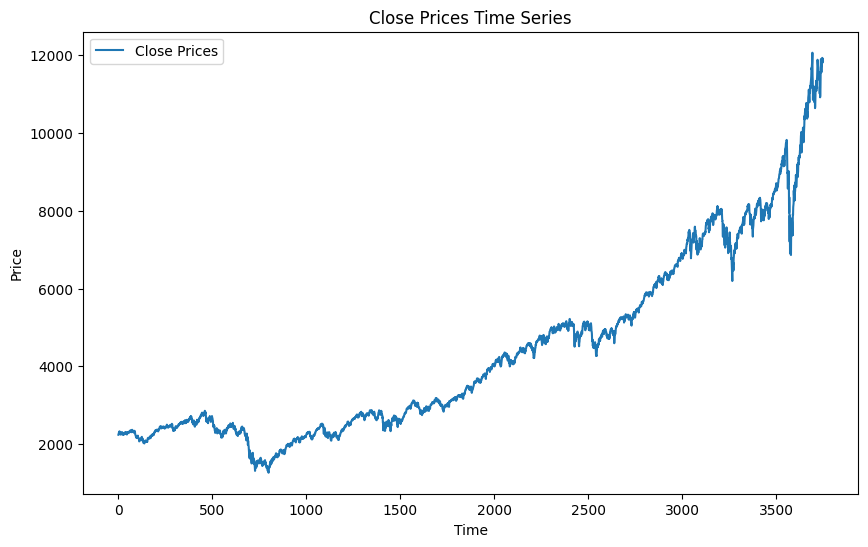

ADF Statistic: 2.536102701310992
p-value: 0.9990605751787489
Critical Values:
   1%: -3.4321086178150693
   5%: -2.8623170601338375
   10%: -2.5671836401248576

The series is non-stationary (fail to reject null hypothesis).


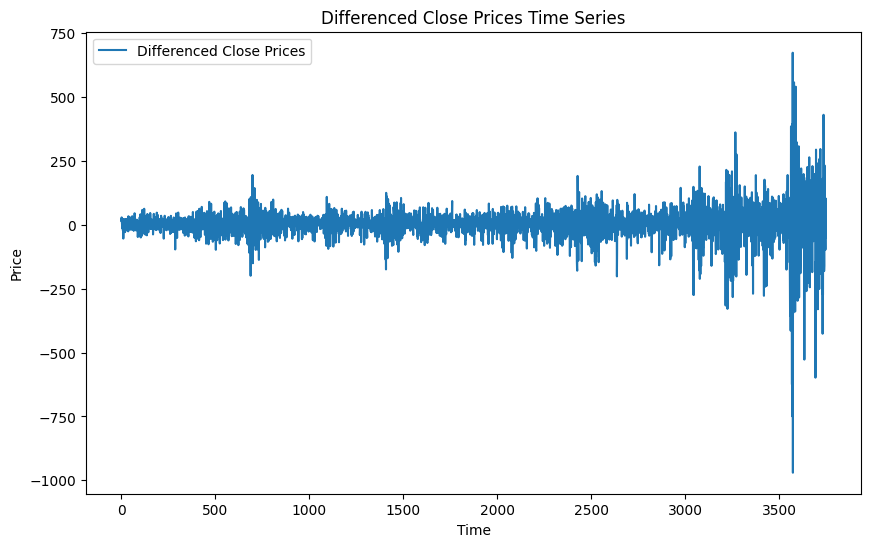


ADF Test on Differenced IXIC:
ADF Statistic: -11.743492696560956
p-value: 1.2573782970807546e-21
Critical Values:
   1%: -3.432109564216738
   5%: -2.8623174781858136
   10%: -2.567183862680981

The series is stationary (reject null hypothesis).
_____________________________________________________________


ADF Test on W5000:


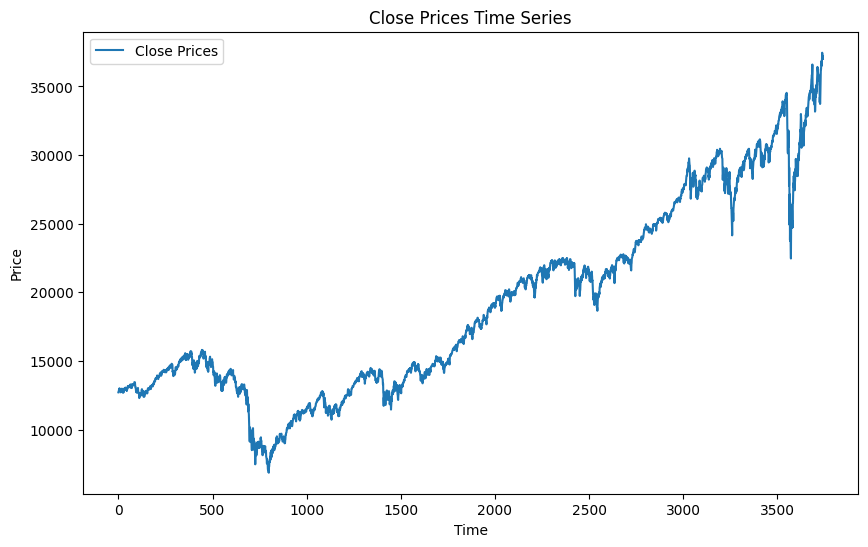

ADF Statistic: 0.697161423750783
p-value: 0.989781050396113
Critical Values:
   1%: -3.4321114600792098
   5%: -2.862318315640672
   10%: -2.567184308512469

The series is non-stationary (fail to reject null hypothesis).


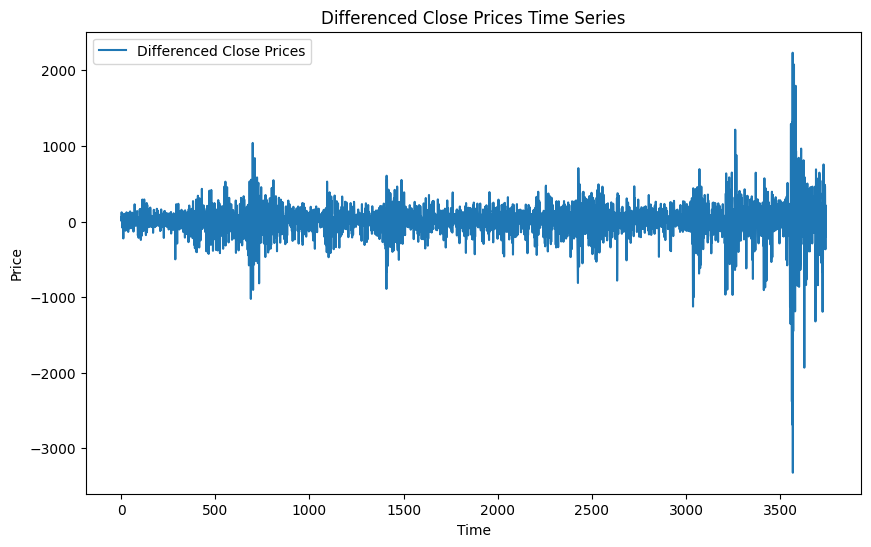


ADF Test on Differenced W5000:
ADF Statistic: -12.476707518705052
p-value: 3.156591673513353e-23
Critical Values:
   1%: -3.4321114600792098
   5%: -2.862318315640672
   10%: -2.567184308512469

The series is stationary (reject null hypothesis).
_____________________________________________________________


ADF Test on XLK:


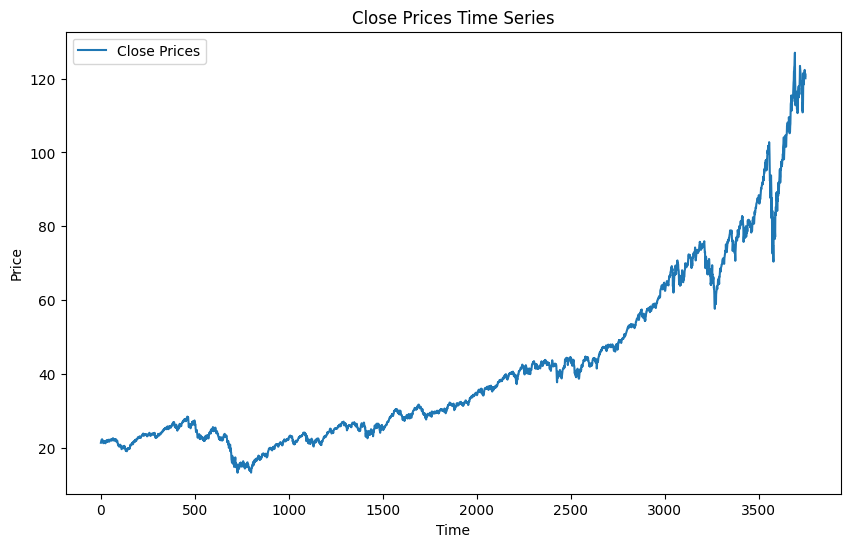

ADF Statistic: 2.7216899943265633
p-value: 0.9990878552953746
Critical Values:
   1%: -3.432109564216738
   5%: -2.8623174781858136
   10%: -2.567183862680981

The series is non-stationary (fail to reject null hypothesis).


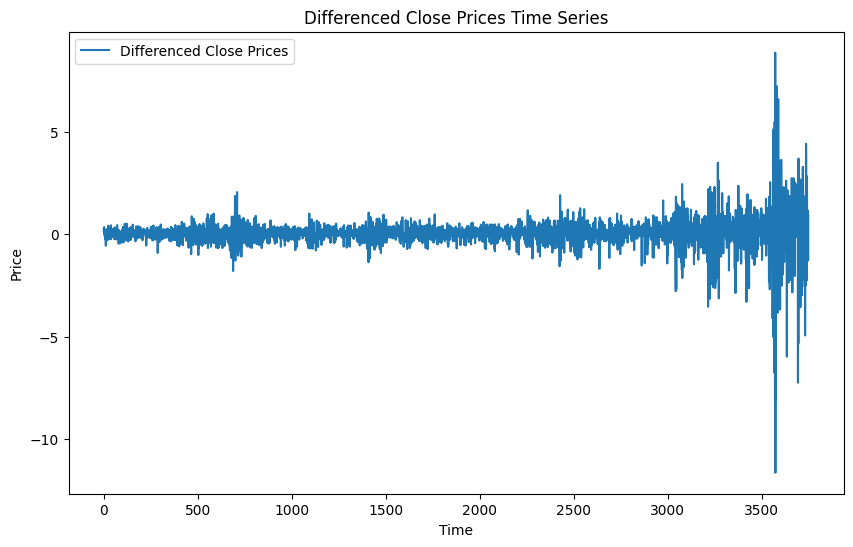


ADF Test on Differenced XLK:
ADF Statistic: -11.5564709153853
p-value: 3.349590345418759e-21
Critical Values:
   1%: -3.432109564216738
   5%: -2.8623174781858136
   10%: -2.567183862680981

The series is stationary (reject null hypothesis).
_____________________________________________________________


ADF Test on GSPC:


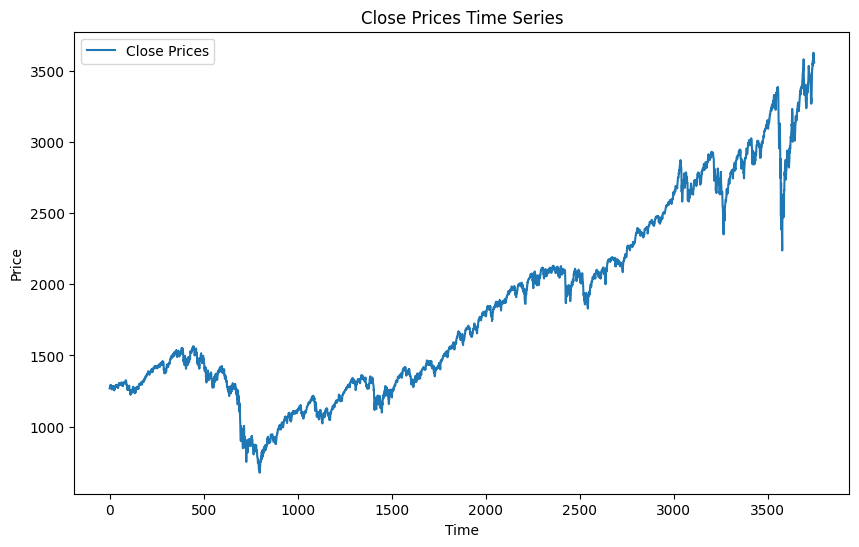

ADF Statistic: 0.8049391050612835
p-value: 0.9917154775535975
Critical Values:
   1%: -3.4321086178150693
   5%: -2.8623170601338375
   10%: -2.5671836401248576

The series is non-stationary (fail to reject null hypothesis).


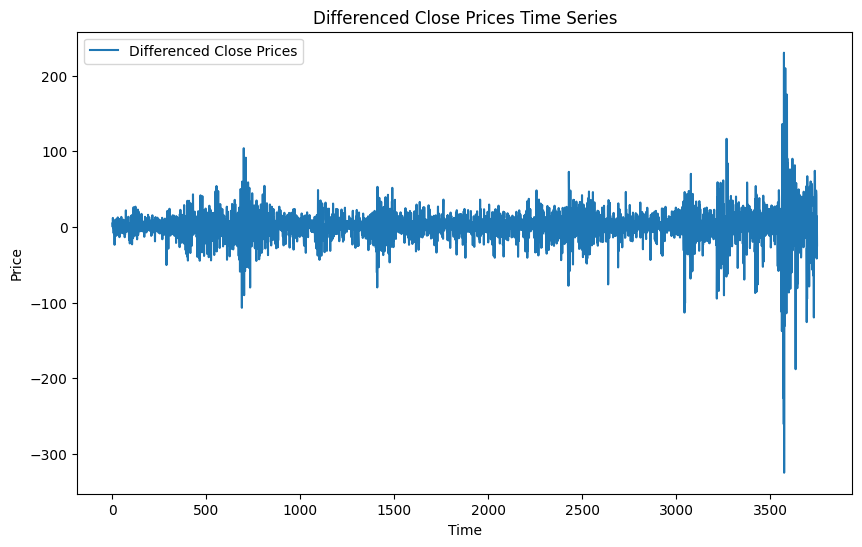


ADF Test on Differenced GSPC:
ADF Statistic: -12.629378067191658
p-value: 1.5166107132329815e-23
Critical Values:
   1%: -3.4321086178150693
   5%: -2.8623170601338375
   10%: -2.5671836401248576

The series is stationary (reject null hypothesis).
_____________________________________________________________


ADF Test on DJI:


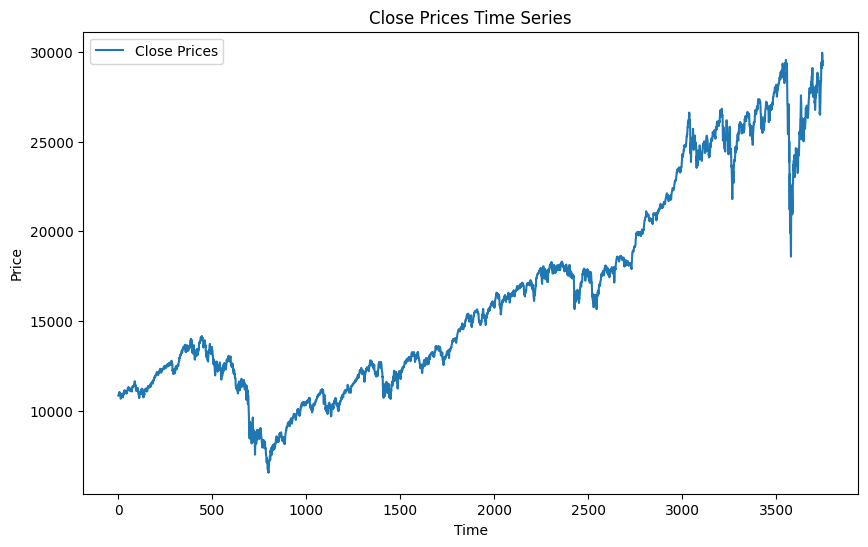

ADF Statistic: 0.16030367665122916
p-value: 0.9699451709884737
Critical Values:
   1%: -3.4321086178150693
   5%: -2.8623170601338375
   10%: -2.5671836401248576

The series is non-stationary (fail to reject null hypothesis).


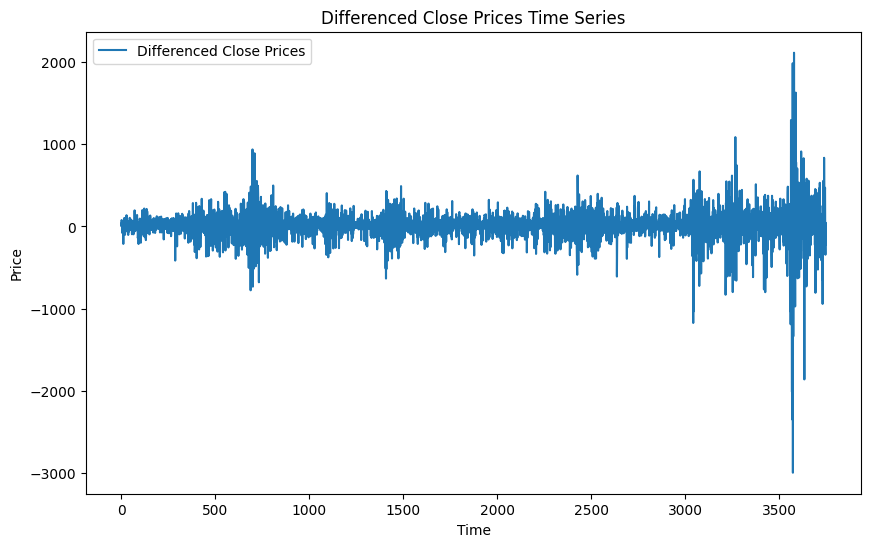


ADF Test on Differenced DJI:
ADF Statistic: -12.356731497205194
p-value: 5.664319258371578e-23
Critical Values:
   1%: -3.4321086178150693
   5%: -2.8623170601338375
   10%: -2.5671836401248576

The series is stationary (reject null hypothesis).
_____________________________________________________________




In [10]:
for i in range(5):
    # Perform ADF test on 'Close' prices
    print(f"ADF Test on {stock_index[i]}:")
    # Plot the differenced series
    plt.figure(figsize=(10, 6))
    plt.plot(np.array(time_series[i]), label='Close Prices')
    plt.title('Close Prices Time Series')
    plt.xlabel('Time')
    plt.ylabel('Price')
    plt.legend()
    plt.show()
    adf_test(time_series[i])

    # Optional: If the series is non-stationary, you can difference it to make it stationary
    # Differencing the series (to remove trends and seasonality)
    diff_series = time_series[i].diff().dropna()
    
    # Plot the differenced series
    plt.figure(figsize=(10, 6))
    plt.plot(diff_series, label='Differenced Close Prices')
    plt.title('Differenced Close Prices Time Series')
    plt.xlabel('Time')
    plt.ylabel('Price')
    plt.legend()
    plt.show()

    # Perform ADF test on the differenced series
    print(f"\nADF Test on Differenced {stock_index[i]}:")
    adf_test(diff_series)
    diff_time_series.append(diff_series)
    print ("_____________________________________________________________\n\n")

# Now fitting SVR on differenced version of the series

In [11]:
def reconstruct_series(diff_series, first_value):
    # Initialize the reconstructed series with the first known value
    reconstructed = [first_value]

    # Iterate through the differenced series and reconstruct
    for diff in diff_series:
        next_value = reconstructed[-1] + diff[0]
        reconstructed.append(next_value)

    return np.array(reconstructed)

In [12]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt

def fit_svr_with_grid_search(time_series,i):
    
    print (f"Stock {stock_index[i]} is being loaded...")
    data = time_series

    t = np.arange(len(data))

    # Step 1: Train-Test Split
    # Let's reserve 20% of the data for testing
    t_train, t_test, y_train, y_test = train_test_split(t, data.values, test_size=0.2, shuffle=False)

    # Step 2: Fit linear regression on the training set to capture the trend
    lr = LinearRegression()
    lr.fit(t_train.reshape(-1, 1), y_train)

    # Predicted trend for both training and testing data
    trend_train_pred = lr.predict(t_train.reshape(-1, 1))
    trend_test_pred = lr.predict(t_test.reshape(-1, 1))

    # Step 3: Calculate residuals (errors) from the trend for training data
    residuals_train = y_train - trend_train_pred

    # Step 4: Scale the time indices for SVR
    scaler = StandardScaler()
    t_train_scaled = scaler.fit_transform(t_train.reshape(-1, 1))
    t_test_scaled = scaler.transform(t_test.reshape(-1, 1))

    # Step 5: Define the SVR model and perform grid search
    svr = SVR(kernel='rbf')
    param_grid = {
        'C': [0.1, 1, 10, 100,1000,2000],      # Regularization parameter
        'gamma': ['scale',0.5, 0.1, 0.01, 0.001],  # Kernel coefficient
        'epsilon': [0.01, 0.1, 0.2]   # Epsilon in the epsilon-SVR model
    }

    grid_search = GridSearchCV(svr, param_grid, cv=KFold(n_splits=5, shuffle=False), scoring='neg_mean_absolute_error', n_jobs=-1)
    grid_search.fit(t_train_scaled, residuals_train)

    # Step 6: Predict using the best estimator from the grid search
    best_svr = grid_search.best_estimator_

    error_train_pred = best_svr.predict(t_train_scaled)
    error_test_pred = best_svr.predict(t_test_scaled)

    # Step 7: Combine the trend and SVR-predicted errors to get the final predictions
    final_train_pred = trend_train_pred + error_train_pred
    final_test_pred = trend_test_pred + error_test_pred

    # Calculate Mean Absolute Error
    mae = mean_absolute_error(final_test_pred, y_test)
    print(f"Mean Absolute Error on Test Set: {mae}")

    # Step 8: Plot the results
    plt.figure(figsize=(10, 6))
    plt.plot(t, data, label='Original Time Series')
    plt.plot(t_train, final_train_pred, label='Train Prediction (Trend + SVR)', linestyle='-.')
    plt.plot(t_test, final_test_pred, label='Test Prediction (Trend + SVR)', linestyle='-.')
    plt.legend()
    plt.title('Time Series Decomposition with Linear Regression and SVR (with Grid Search)')
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.show()

    # Print the best parameters and cross-validation score
    print(f"Best SVR parameters: {grid_search.best_params_}")
    print(f"Best cross-validation score: {grid_search.best_score_}")



In [13]:
for i in range(len(diff_time_series)):
#     hyperparameter_c = best_svr[i][0]
#     hyperparameter_k = best_svr[i][1]
#     hyperparameter_gamma = best_svr[i][2]
    fit_svr_with_grid_search(time_series[i],i)

Stock IXIC is being loaded...


/opt/conda/lib/python3.10/site-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


KeyboardInterrupt: 

In [14]:
import numpy as np
import matplotlib.pyplot as plt


def do_freq_analysis(time_series, index, log_trans):
    # Sampling frequency (assuming a fixed value, change if needed)
    fs = 1000  # Sampling frequency in Hz
    t = np.arange(0, len(time_series) / fs, 1/fs)  # Time vector based on the length of time_series

    # Perform Fast Fourier Transform (FFT)
    fft_result = np.fft.fft(time_series)
    fft_magnitude = np.abs(fft_result)  # Magnitude of the FFT
    fft_freq = np.fft.fftfreq(len(time_series), 1/fs)  # Frequency axis

    # Plotting the original time series
    plt.figure(figsize=(14, 6))

    plt.subplot(1, 2, 1)
    plt.plot(t, time_series)
    plt.title(f'Time Series Signal {stock_index[index]}')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.grid()

    # Plotting the frequency domain representation
    plt.subplot(1, 2, 2)
    # Only plot positive frequencies
    pos_indices = fft_freq > 0
    freq_to_plot = fft_freq[pos_indices]
    magnitude_to_plot = fft_magnitude[pos_indices]

    if log_trans:
        # Apply log transformation to the magnitude
        magnitude_to_plot = np.log1p(magnitude_to_plot)  # log(1 + magnitude) to avoid log(0)

    plt.plot(freq_to_plot, magnitude_to_plot)
    plt.title(f'Frequency Domain (FFT) {stock_index[index]}' + (' (Log Transformed)' if log_trans else ''))
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Magnitude' + (' (Log Scale)' if log_trans else ''))
    plt.grid()

    plt.tight_layout()
    plt.show()

# Frequency Domain Analysis

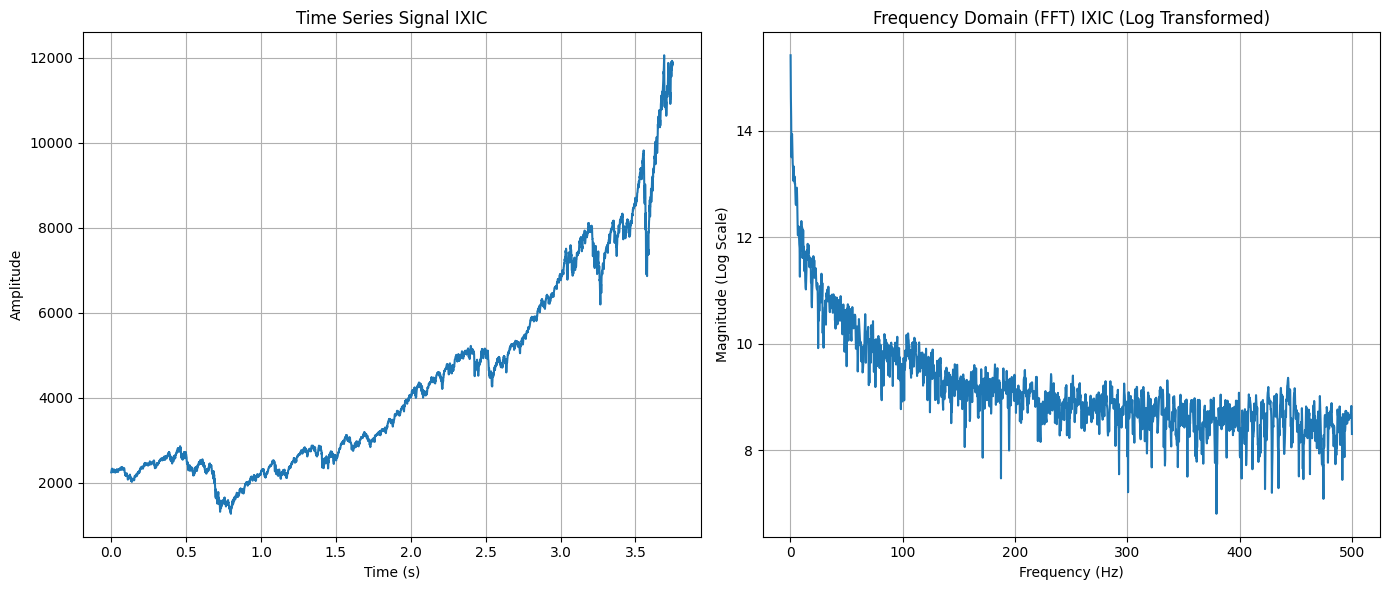

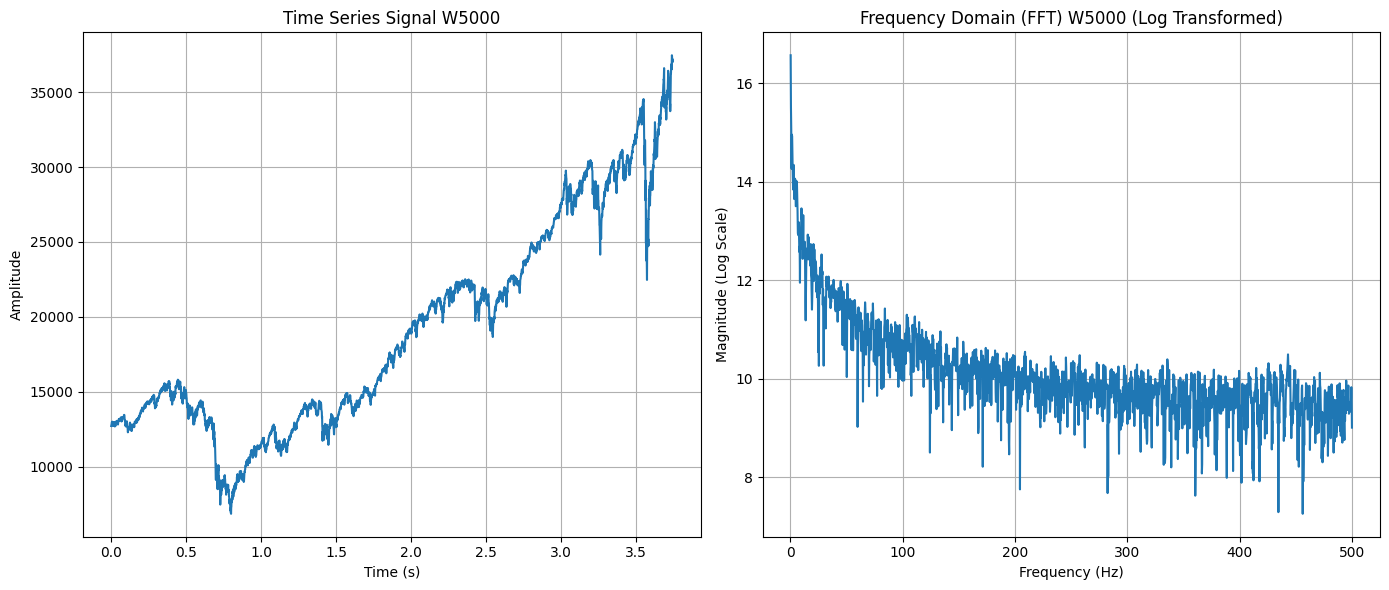

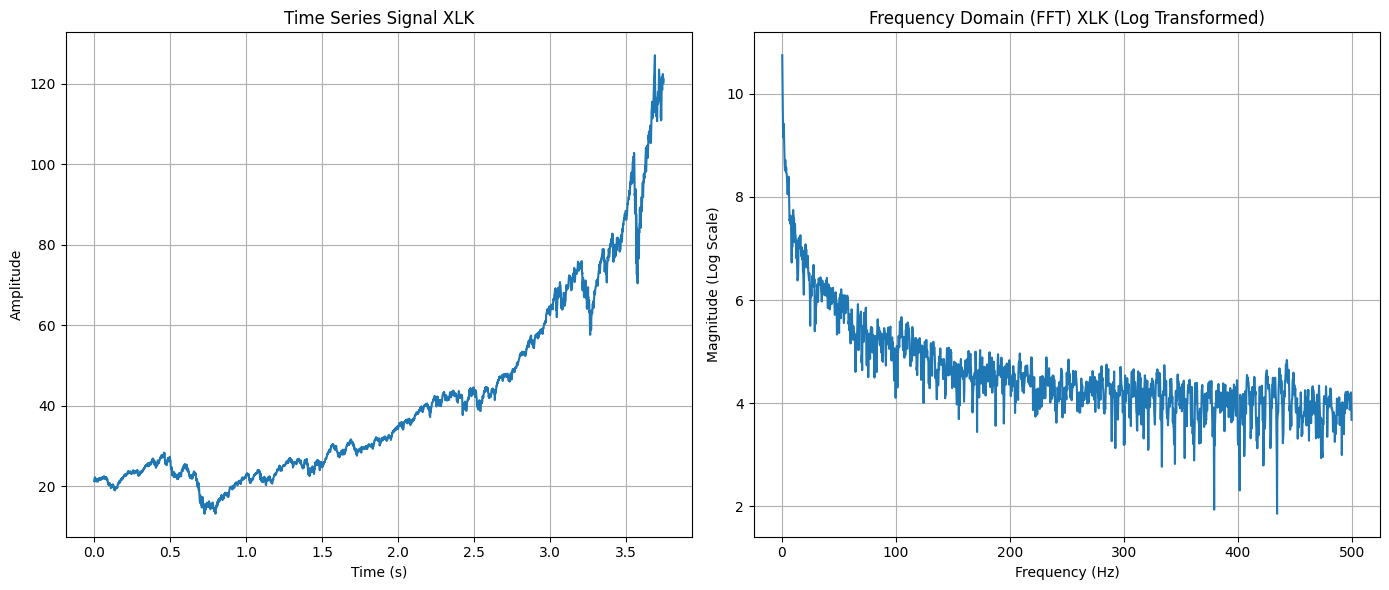

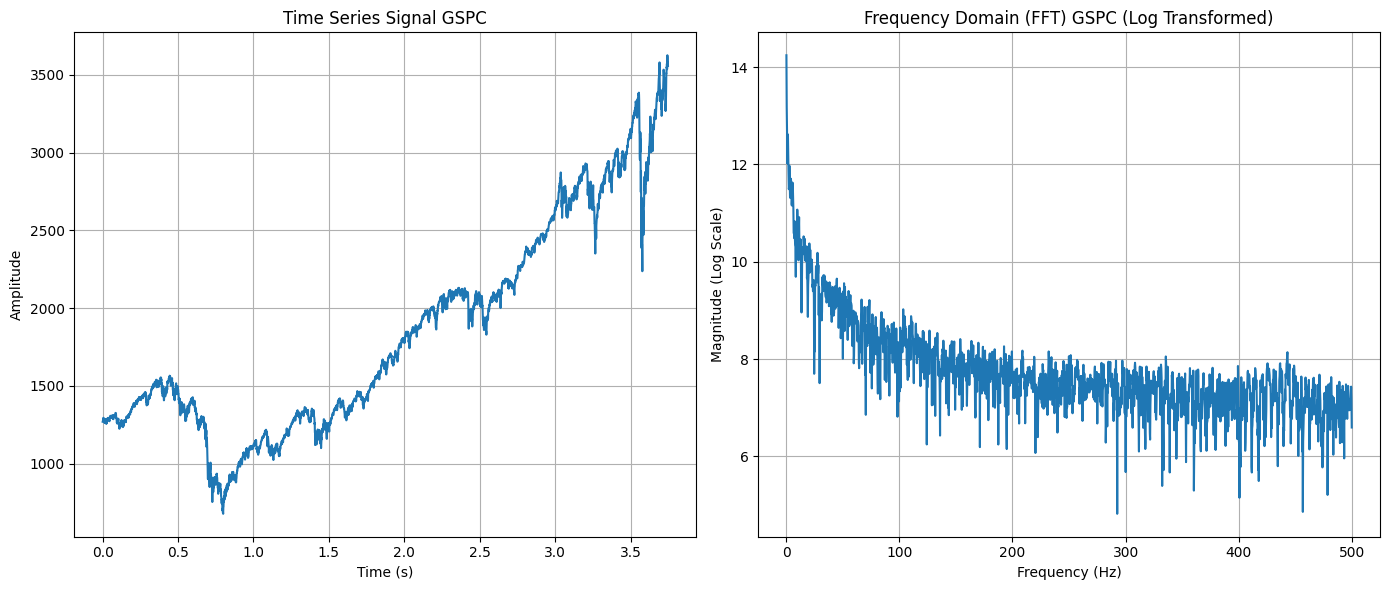

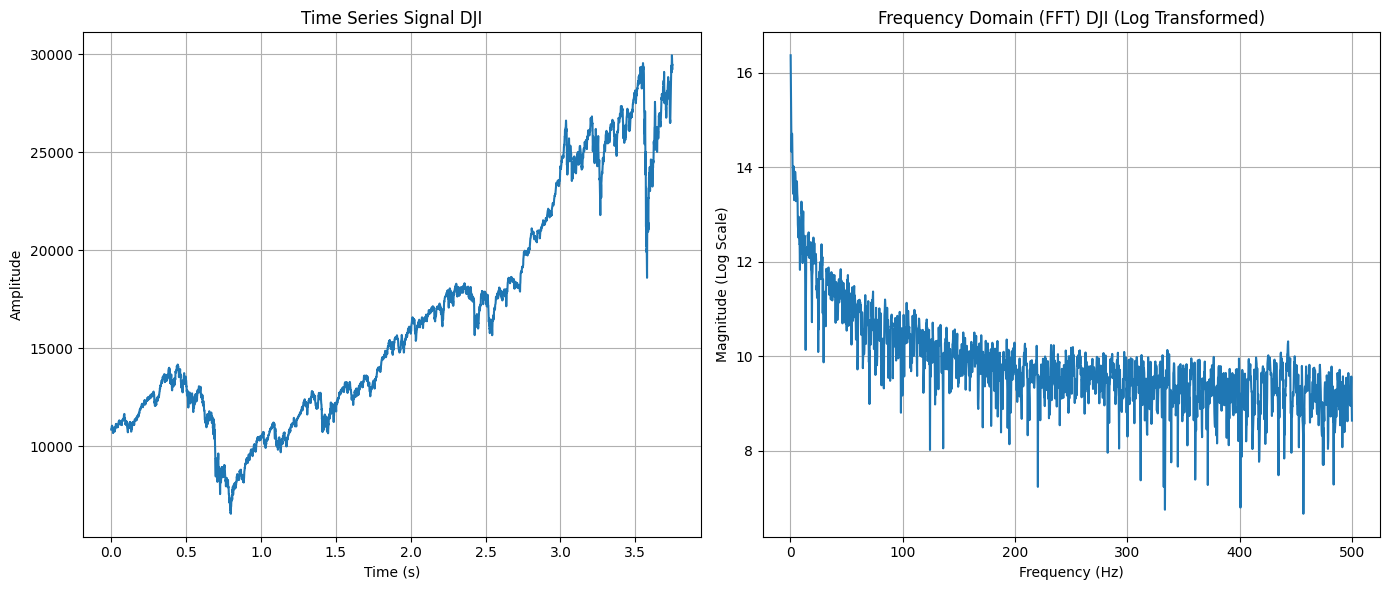

In [15]:
for i in range(len(diff_time_series)):
    do_freq_analysis(time_series[i], i,True)

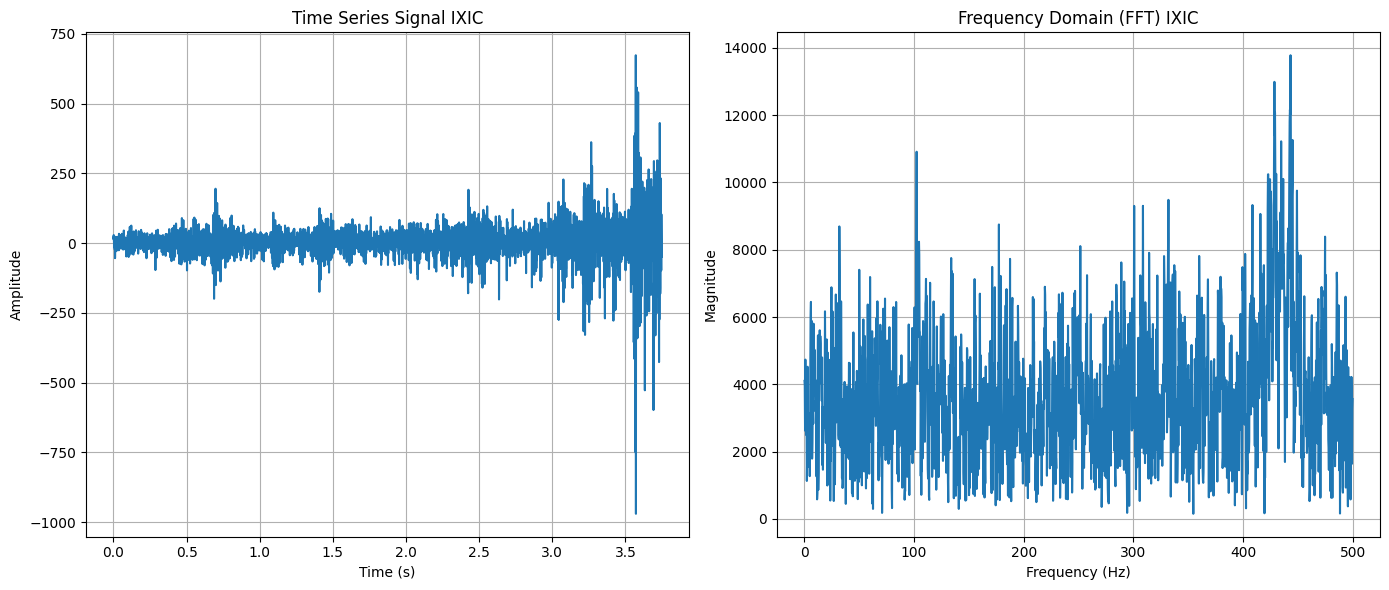

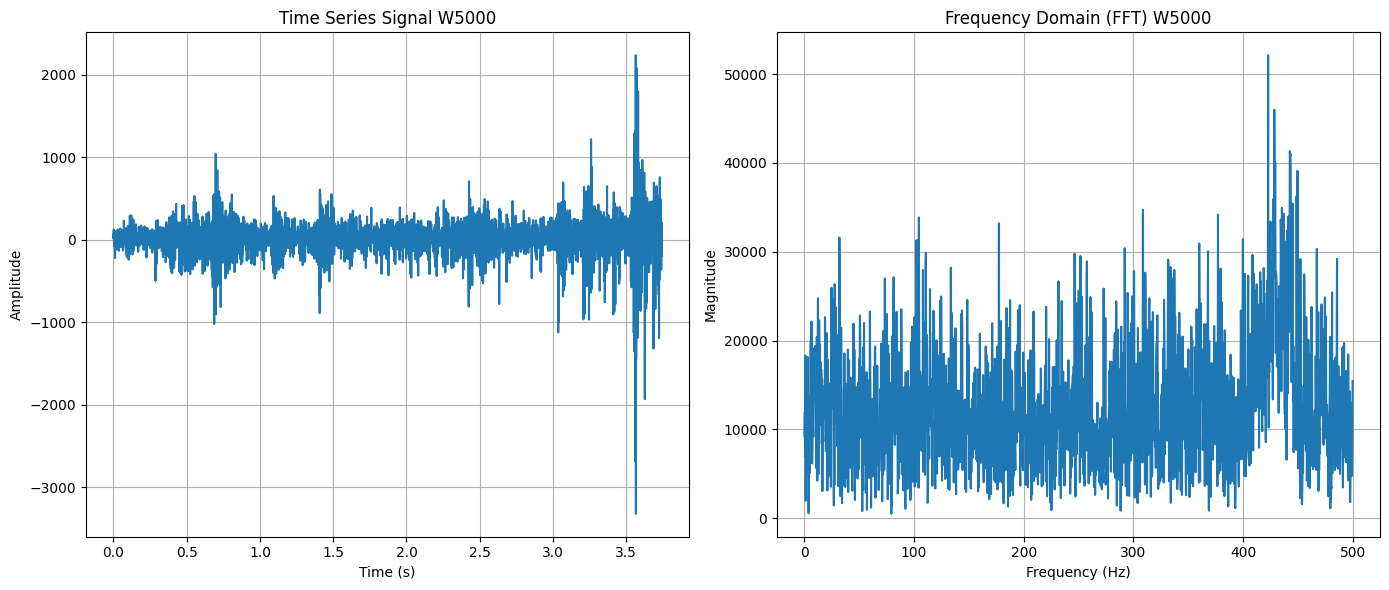

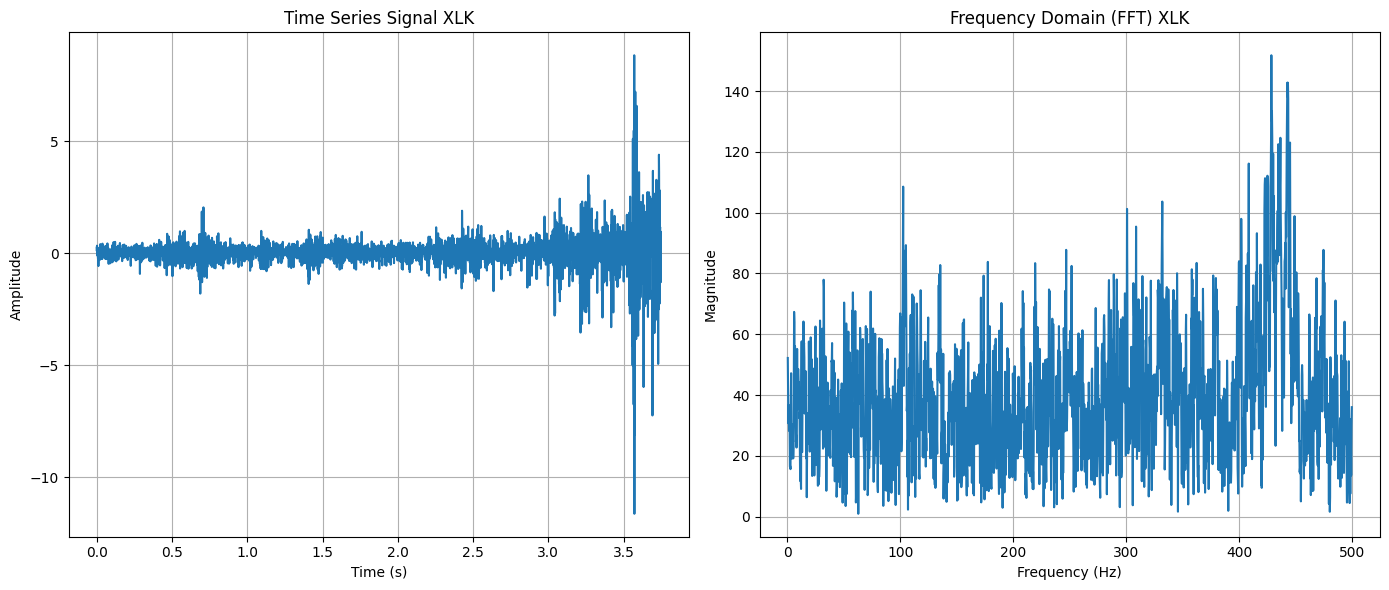

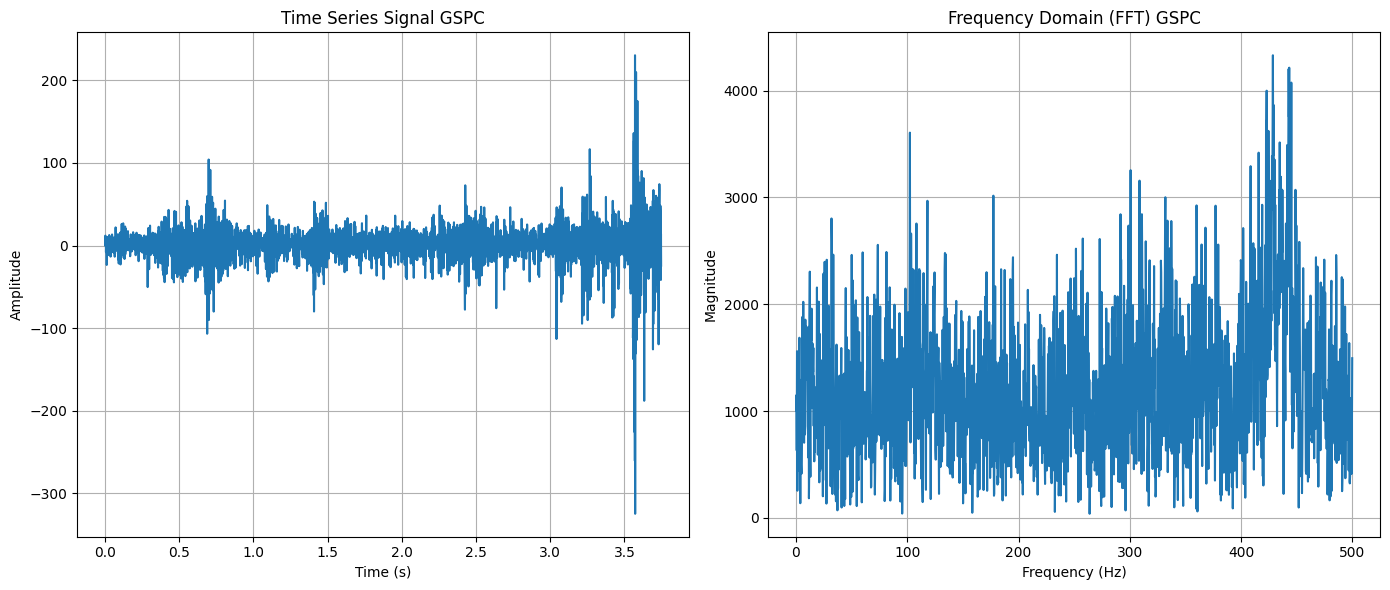

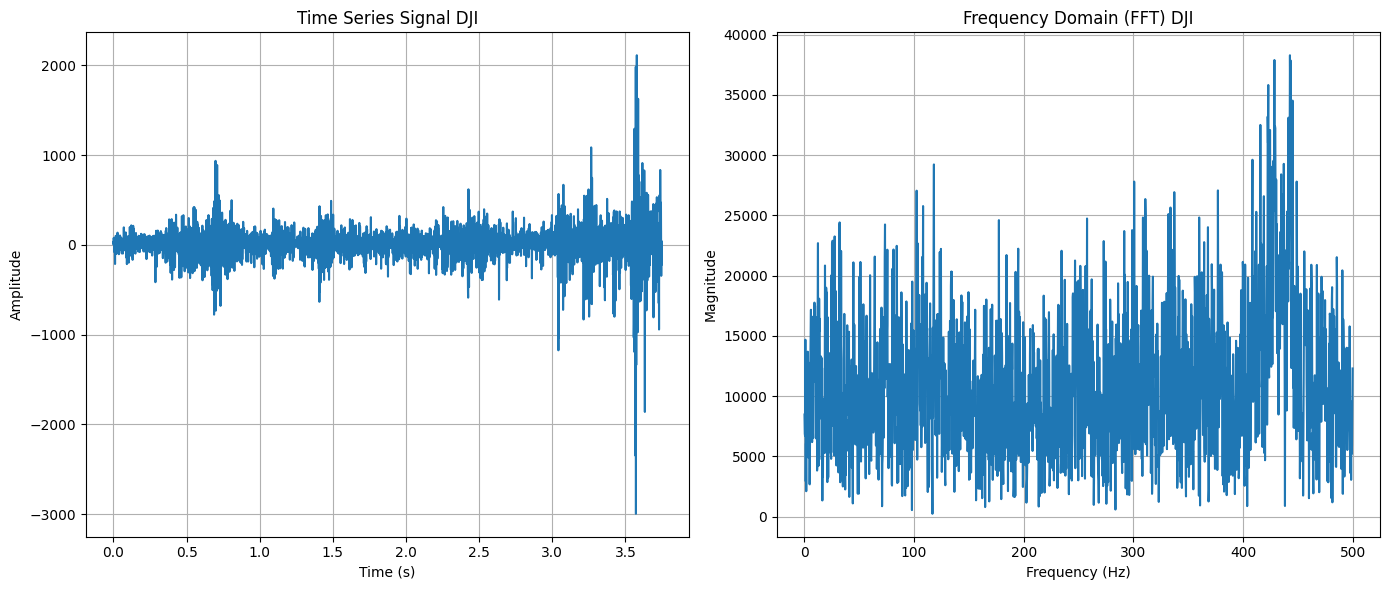

In [16]:
for i in range(len(diff_time_series)):
    do_freq_analysis(diff_time_series[i], i,False)